# Imports

In [66]:
import numpy as np
import pandas as pd 
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

# Import Data 

In [67]:
ticker = yf.Ticker("AAPL")

df = ticker.history(period="1y")  # 1 an d'historique
print(df)

                                 Open        High         Low       Close  \
Date                                                                        
2024-11-22 00:00:00-05:00  227.033174  229.681201  227.033174  228.835022   
2024-11-25 00:00:00-05:00  230.417878  232.199812  228.705621  231.821518   
2024-11-26 00:00:00-05:00  232.279457  234.509377  232.279457  234.001663   
2024-11-27 00:00:00-05:00  233.414333  234.628841  232.757301  233.872253   
2024-11-29 00:00:00-05:00  233.752786  236.739279  232.916572  236.261444   
...                               ...         ...         ...         ...   
2025-11-17 00:00:00-05:00  268.820007  270.489990  265.730011  267.459991   
2025-11-18 00:00:00-05:00  269.989990  270.709991  265.320007  267.440002   
2025-11-19 00:00:00-05:00  265.529999  272.209991  265.500000  268.559998   
2025-11-20 00:00:00-05:00  270.829987  275.429993  265.920013  266.250000   
2025-11-21 00:00:00-05:00  265.950012  273.329987  265.670013  271.489990   

In [68]:
prices = df['Close']

<Axes: xlabel='Date'>

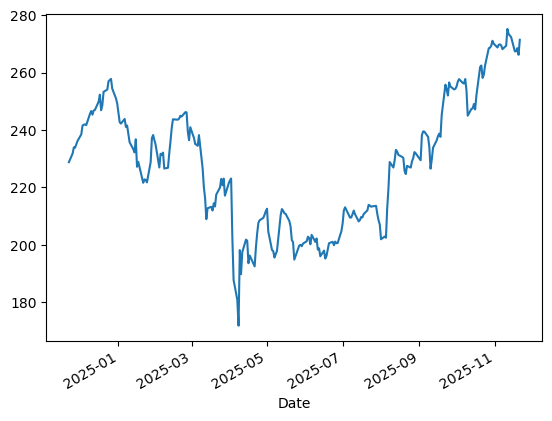

In [69]:
prices.plot()

In [70]:
print(np.std(prices)/100)

0.22613567753906014


# Price the Option

In [71]:
def price_option(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    call_price = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

    return call_price

In [72]:
apple_option = price_option(prices[0],270,1,0.05,np.std(prices)/100)
print(apple_option)

10.633743711718907


/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_1564/2496579041.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  apple_option = price_option(prices[0],270,1,0.05,np.std(prices)/100)


# Compute Delta

In [73]:
def delta_BS(S,K,T,r,sigma):
    d1 = (np.log(S/K) + (r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1)

In [74]:
delta_value = []
hedge = []
dates = []
call_price = []

n = len(prices)

for date, val in prices.items():
    position = prices.index.get_loc(date)
    T = (n - position) / n   # time to maturity normalisé

    delta_value.append(
        delta_BS(val, 270, 0.05, np.std(prices)/100, T)
    )
    delta = delta_BS(val, 270, 0.05, np.std(prices)/100, T)
    call_price += [price_option(val,270,T,0.05,np.std(prices)/100)]
    dates += [date]
    hedge += [delta * val]

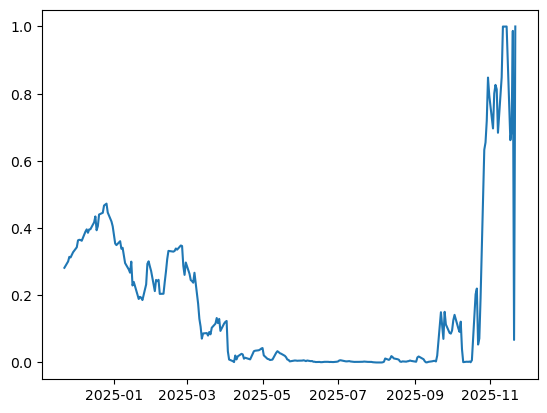

In [75]:
plt.plot(dates, delta_value)
plt.show()

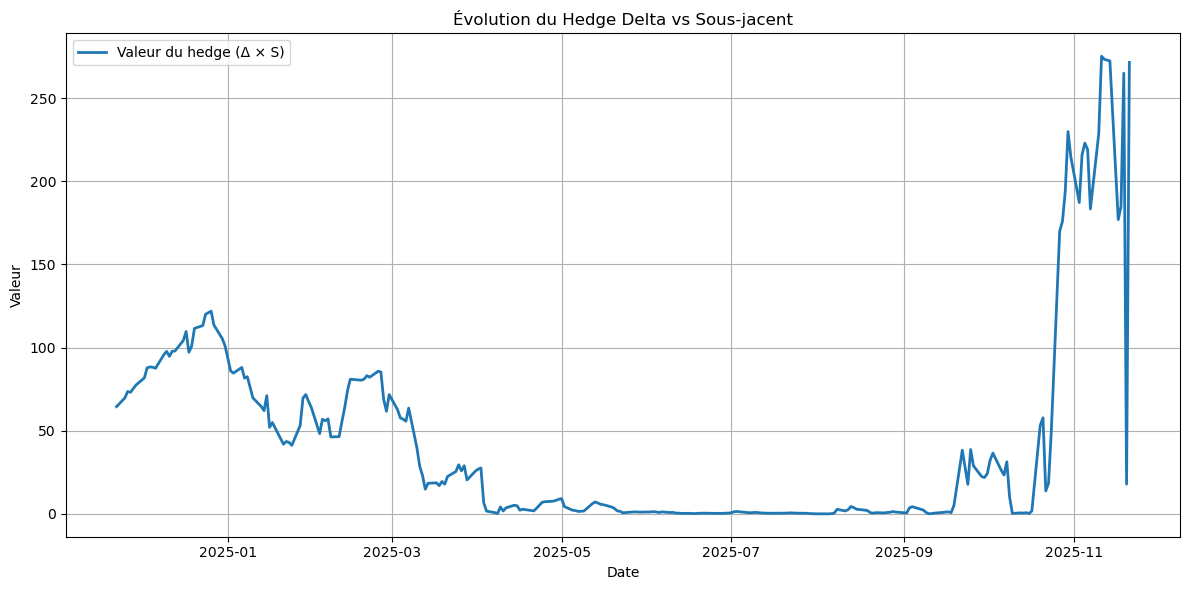

In [76]:
plt.figure(figsize=(12, 6))

plt.plot(dates, hedge, label="Valeur du hedge (Δ × S)", linewidth=2)
# plt.plot(dates, delta_value, label="Delta", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Valeur")
plt.title("Évolution du Hedge Delta vs Sous-jacent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Hedge a portfolio

In [77]:
df = pd.DataFrame({
    "Price": prices.values,
    "Delta": delta_value
}, index=dates)

# Payoff du call à maturité
K = 270
df["Payoff"] = np.maximum(df["Price"].iloc[-1] - K, 0)

# Variations du sous-jacent
df["dS"] = df["Price"].diff()

# Hedge PNL : - ∑ delta_t * dS_{t+1}
df["HedgePNL"] = -(df["Delta"].shift(1) * df["dS"])
df["HedgePNL"].fillna(0, inplace=True)

# PNL cumulé du hedge
df["CumHedgePNL"] = df["HedgePNL"].cumsum()

# Portefeuille delta hedgé
df["PNL_Hedged"] = df["CumHedgePNL"] + df["Payoff"]

# Benchmark : long stock
df["PNL_LongStock"] = df["Price"] - df["Price"].iloc[0]


/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_1564/2033620682.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["HedgePNL"].fillna(0, inplace=True)


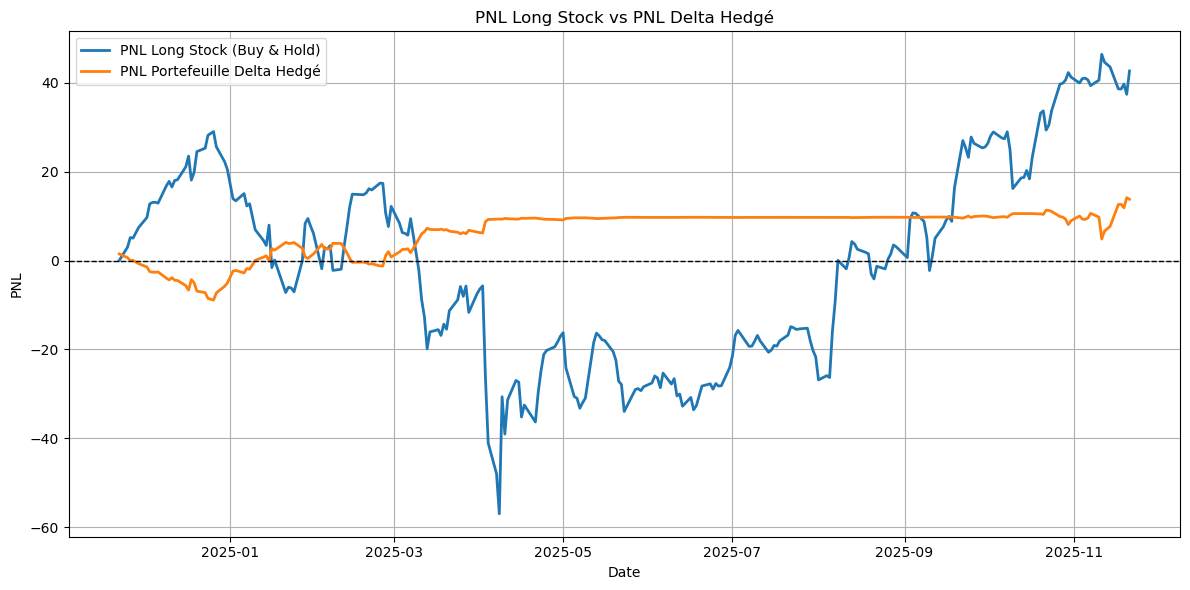

In [78]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df["PNL_LongStock"], label="PNL Long Stock (Buy & Hold)", linewidth=2)
plt.plot(df.index, df["PNL_Hedged"], label="PNL Portefeuille Delta Hedgé", linewidth=2)

plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.title("PNL Long Stock vs PNL Delta Hedgé")
plt.xlabel("Date")
plt.ylabel("PNL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: >

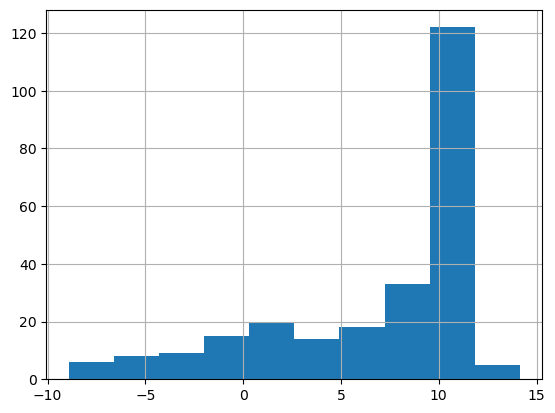

In [79]:
df["PNL_Hedged"].hist()

In [80]:
df = pd.DataFrame({
    "Price": prices.values,
    "Delta": delta_value
}, index=dates)

K = 270

# Payoff du call à maturité
df["Payoff"] = np.maximum(df["Price"].iloc[-1] - K, 0)

# Variation du sous-jacent
df["dS"] = df["Price"].diff()

# Flux long delta (on multiplie par la variation du prix)
df["LongDeltaFlow"] = df["Delta"].shift(1) * df["dS"]
df["LongDeltaFlow"].fillna(0, inplace=True)

df["CumLongDelta"] = df["LongDeltaFlow"].cumsum()

# PNL final = hedging + payoff (perdu)
df["PNL_LongDeltaShortCall"] = df["CumLongDelta"] - df["Payoff"]

df["PNL_LongStock"] = df["Price"] - df["Price"].iloc[0]

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_1564/2886225229.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["LongDeltaFlow"].fillna(0, inplace=True)


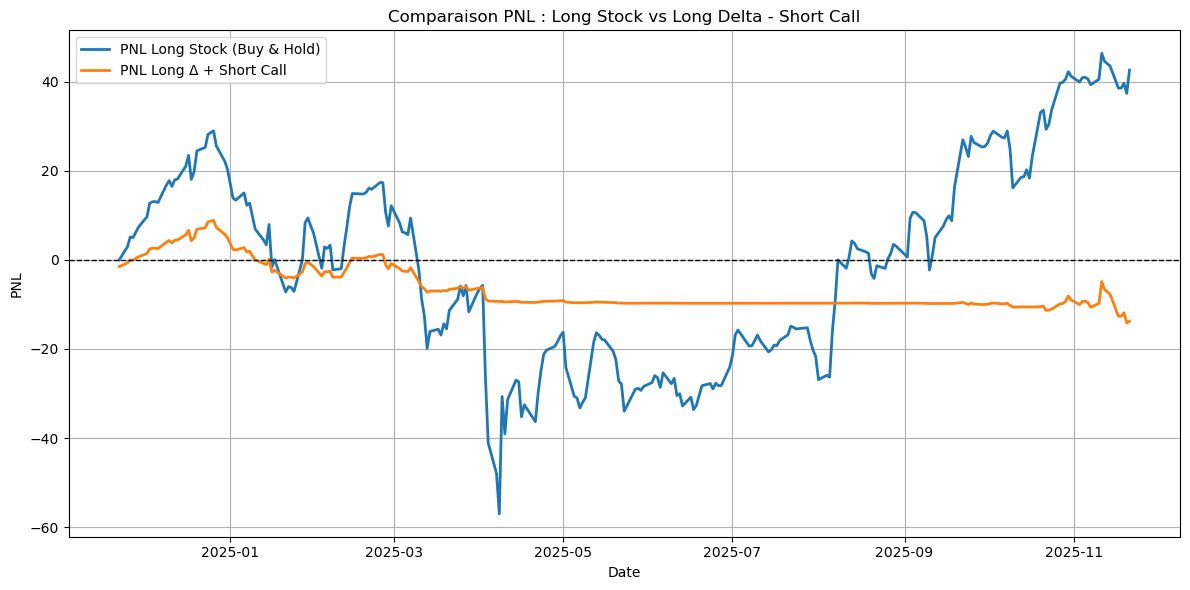

In [81]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df["PNL_LongStock"], 
         label="PNL Long Stock (Buy & Hold)", linewidth=2)

plt.plot(df.index, df["PNL_LongDeltaShortCall"], 
         label="PNL Long Δ + Short Call", linewidth=2)

plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.title("Comparaison PNL : Long Stock vs Long Delta - Short Call")
plt.xlabel("Date")
plt.ylabel("PNL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Hedging Mean-Variance Portfolio

In [91]:
from sklearn.linear_model import LinearRegression
import cvxpy as cp

In [92]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META"]
market_ticker = "SPY"

data = yf.download(tickers + [market_ticker], start="2018-01-01", end="2025-01-01")["Close"]
returns = data.pct_change().dropna()

stock_returns = returns[tickers]
market_returns = returns[market_ticker]

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_1564/4090682401.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers + [market_ticker], start="2018-01-01", end="2025-01-01")["Close"]
[*********************100%***********************]  6 of 6 completed


In [93]:
all_assets = tickers + [market_ticker]

In [94]:
alphas = []
betas = []

X = market_returns.values.reshape(-1,1)

for t in tickers:
    y = stock_returns[t].values
    reg = LinearRegression().fit(X, y)
    alphas.append(reg.intercept_)
    betas.append(reg.coef_[0])

alpha = np.array(alphas)
beta = np.array(betas)

df_factors = pd.DataFrame({"alpha": alpha, "beta": beta}, index=tickers)
df_factors

,alpha,beta
AAPL,0.000508,1.222027
MSFT,0.000400,1.222797
AMZN,0.000293,1.172652
GOOGL,0.000218,1.181546
META,0.000254,1.317559


In [95]:
mu_mkt = market_returns.mean()
mu_stock = alpha + beta * mu_mkt

In [96]:
cov = stock_returns.cov().values
var_mkt = market_returns.var()
cov_stock_mkt = stock_returns.apply(lambda x: x.cov(market_returns)).values

In [97]:
mu_mkt = market_returns.mean()
mu_stock = alpha + beta * mu_mkt

# Expected returns for 6 assets (5 stocks + SPY)
mu = np.concatenate([mu_stock, [mu_mkt]])

# Covariance matrix for 6 assets
cov = returns[all_assets].cov().values

n = cov.shape[0]

In [98]:
w = cp.Variable(n)   # now includes SPY hedge weight
lam = 5              # risk aversion

portfolio_return = mu @ w
portfolio_var = cp.quad_form(w, cov)

objective = cp.Maximize(portfolio_return - lam * portfolio_var)

constraints = [
    cp.sum(w[:-1]) == 1,   # ONLY stock weights sum to 1
    # w[-1] (SPY) is free: can hedge long/short
]

problem = cp.Problem(objective, constraints)
problem.solve()

opt_w = w.value
stock_weights = opt_w[:-1]
hedge_weight = opt_w[-1]

print("Optimal stocks weight:", stock_weights)
print("Optimal hedge (SPY):", hedge_weight)

Optimal stocks weight: [0.41540899 0.44757651 0.0312627  0.09343646 0.01231534]
Optimal hedge (SPY): -0.830369818349088


In [99]:
portfolio_returns = returns[all_assets].mul(opt_w).sum(axis=1)
portfolio_cum = (1 + portfolio_returns).cumprod()
market_cum = (1 + market_returns).cumprod()

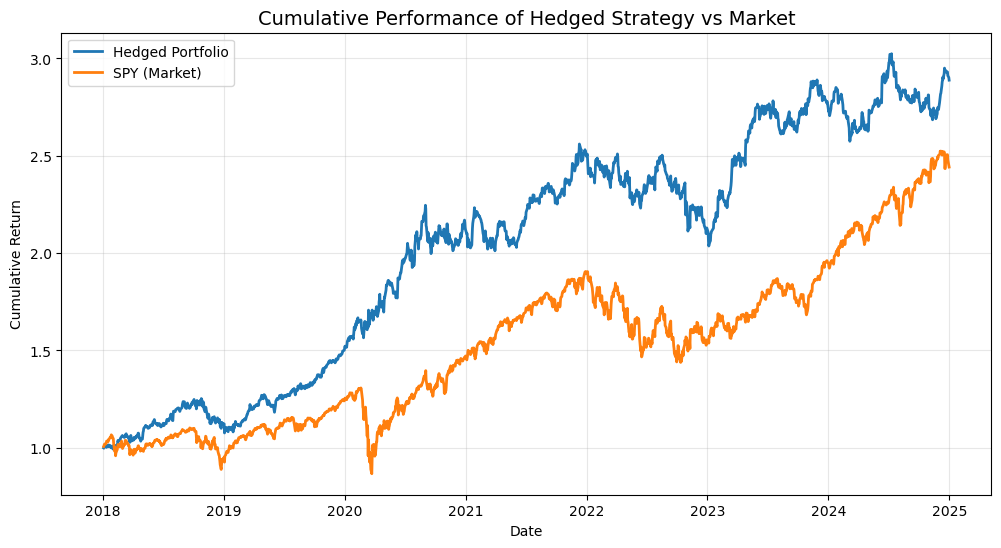

In [100]:
plt.figure(figsize=(12,6))
plt.plot(portfolio_cum, label="Hedged Portfolio", linewidth=2)
plt.plot(market_cum, label="SPY (Market)", linewidth=2)

plt.title("Cumulative Performance of Hedged Strategy vs Market", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [101]:
# -----------------------------------------------
# Sharpe Ratio
# -----------------------------------------------
def sharpe_ratio(returns, risk_free_rate=0.0):
    """
    returns: daily PnL or daily returns of the strategy
    risk_free_rate: daily risk-free rate (put 0 if negligible)
    """
    excess_ret = returns - risk_free_rate
    return np.sqrt(252) * excess_ret.mean() / excess_ret.std()


# -----------------------------------------------
# Information Ratio
# -----------------------------------------------
def information_ratio(strategy_returns, benchmark_returns):
    """
    strategy_returns: daily returns of the strategy
    benchmark_returns: daily returns of the benchmark / market
    """
    active_returns = strategy_returns - benchmark_returns
    return np.sqrt(252) * active_returns.mean() / active_returns.std()


# -----------------------------------------------
# Net Exposure
# -----------------------------------------------
def net_exposure(weights):
    """
    weights: vector or dataframe of portfolio weights
    """
    return weights.sum()

In [102]:
sr = sharpe_ratio(portfolio_returns)
print("Sharpe Ratio:", sr)

Sharpe Ratio: 1.0734162667778386


In [103]:
ir = information_ratio(portfolio_returns, market_returns)
print("Information Ratio:", ir)

Information Ratio: 0.09337727455638399


In [109]:
weights = np.append(stock_weights, hedge_weight)
ne = net_exposure(weights)
print("Net Exposure:", ne)

Net Exposure: 0.16963018165091204
